In [13]:
# !pip install matplotlib
# !pip install statsmodels
# !pip install scipy
# !pip install openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as scistat



In [14]:
covidtotals = pd.read_csv('data/covidtotals.csv')
covidtotals.set_index('iso_code', inplace=True)

totvars = ['location','total_cases',
            'total_deaths','total_cases_pm',
            'total_deaths_pm']

demovars = ['population','pop_density',
            'median_age','gdp_per_capita',
            'hosp_beds','hum_dev_ind']



In [15]:
covidtotalsonly = covidtotals.loc[:,totvars]
covidtotalsonly.describe()

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
count,2.310000e+02,2.310000e+02,231.000000,231.000000
mean,3.351599e+06,3.021420e+04,206177.794623,1261.778390
std,1.148321e+07,1.047789e+05,203858.096252,1314.981529
min,4.000000e+00,0.000000e+00,354.487000,0.000000
25%,2.567150e+04,1.775000e+02,21821.863000,141.177000
50%,1.914960e+05,1.937000e+03,133946.251000,827.046000
75%,1.294286e+06,1.415000e+04,345689.831000,1997.513000
max,1.034368e+08,1.127152e+06,763475.441000,6507.656000


In [16]:
covidtotalsonly.quantile(np.arange(0,1.1,0.1), numeric_only=True)

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
0.0,4.0,0.0,354.487,0.000
0.1,8359.0,31.0,3138.575,32.885
0.2,17181.0,126.0,10885.737,105.298
0.3,38008.0,294.0,35834.604,210.509
0.4,74129.0,844.0,86126.235,498.789
0.5,191496.0,1937.0,133946.251,827.046
0.6,472755.0,4384.0,220429.369,1251.299
0.7,1041111.0,9646.0,293737.443,1697.571
0.8,1877065.0,21218.0,416608.106,2271.676
0.9,5641992.0,62288.0,512388.401,3155.939


In [17]:
covidtotalsonly.skew(numeric_only=True)

total_cases        6.307179
total_deaths       7.098945
total_cases_pm     0.834903
total_deaths_pm    1.252925
dtype: float64

In [18]:
covidtotalsonly.kurt(numeric_only=True)

total_cases        47.080248
total_deaths       61.727944
total_cases_pm     -0.428060
total_deaths_pm     1.256217
dtype: float64

In [19]:
def testnorm(var, df):
    stat, p = scistat.shapiro(df[var])
    return p

print('Total cases: %.5f' % testnorm('total_cases', covidtotalsonly))
print('Total deaths: %.5f' % testnorm('total_deaths', covidtotalsonly))
print('Total cases pm: %.5f' % testnorm('total_cases_pm', covidtotalsonly))
print('Total deaths pm: %.5f' % testnorm('total_deaths_pm', covidtotalsonly))



Total cases: 0.00000
Total deaths: 0.00000
Total cases pm: 0.00000
Total deaths pm: 0.00000


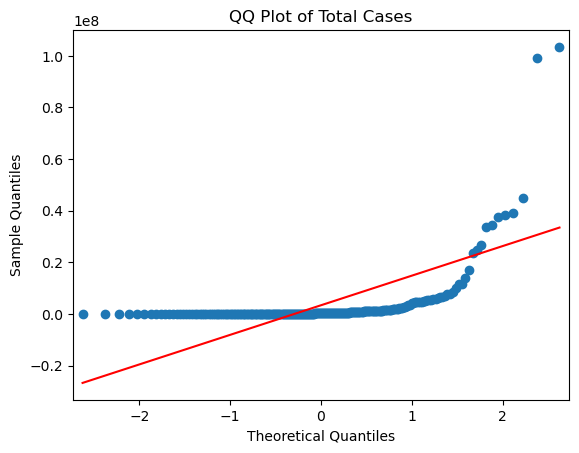

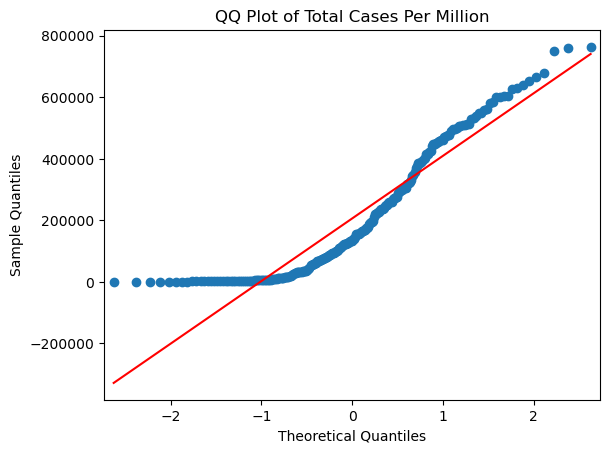

In [20]:
sm.qqplot(covidtotalsonly[['total_cases']].
    sort_values(['total_cases']), line='s')
plt.title('QQ Plot of Total Cases')
sm.qqplot(covidtotalsonly[['total_cases_pm']].
    sort_values(['total_cases_pm']), line='s')
plt.title('QQ Plot of Total Cases Per Million')
plt.show()


In [21]:
thirdq, firstq = covidtotalsonly.total_cases.quantile(0.75), covidtotalsonly.total_cases.quantile(0.25)
interquartilerange = 1.5 * (thirdq - firstq)
outlierhigh, outlierlow = thirdq + interquartilerange, firstq - interquartilerange
print(outlierlow, outlierhigh, sep=' <--> ')

-1877250.25 <--> 3197207.75


In [23]:
def getoutliers():
    dfout = pd.DataFrame(columns=covidtotals.columns, data=None)
    for col in covidtotalsonly.columns[1:]:
        thirdq, firstq = covidtotalsonly[col].quantile(0.75), covidtotalsonly[col].quantile(0.25)
        iqr = 1.5*(thirdq-firstq)
        outlierhigh, outlieralow = thirdq+iqr, firstq-iqr
        df = covidtotals.loc[(covidtotals[col]>outlierhigh) | (covidtotals[col]<outlieralow)]
        df = df.assign(varname = col, threshlow = outlieralow, threshhigh = outlierhigh)
        dfout = pd.concat([dfout, df])
    return dfout

outliers = getoutliers()
outliers.varname.value_counts()

C:\Users\LeTrungTin\AppData\Local\Temp\ipykernel_12584\464295835.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfout = pd.concat([dfout, df])


varname
total_cases        39
total_deaths       33
total_deaths_pm     4
Name: count, dtype: int64

In [24]:
outliers.to_excel('views/outliers.xlsx')

In [27]:
outliers.loc[outliers.varname=='total_deaths_pm', ['location', 'total_deaths_pm', 'total_cases_pm', 'median_age', 'hum_dev_ind']].sort_values(['total_deaths_pm'], ascending=False)

,location,total_deaths_pm,total_cases_pm,median_age,hum_dev_ind
PER,Peru,6507.656,133238.998,29.1,0.777
BGR,Bulgaria,5703.518,195767.887,44.7,0.816
BIH,Bosnia and Herzegovina,5066.290,124806.326,42.5,0.780
HUN,Hungary,4918.281,223685.161,43.4,0.854


In [28]:
covidtotals[['total_deaths_pm', 'median_age', 'hum_dev_ind']].quantile([0.25, 0.5, 0.75])

,total_deaths_pm,median_age,hum_dev_ind
0.25,141.177,22.05,0.6015
0.50,827.046,29.60,0.7400
0.75,1997.513,38.70,0.8285


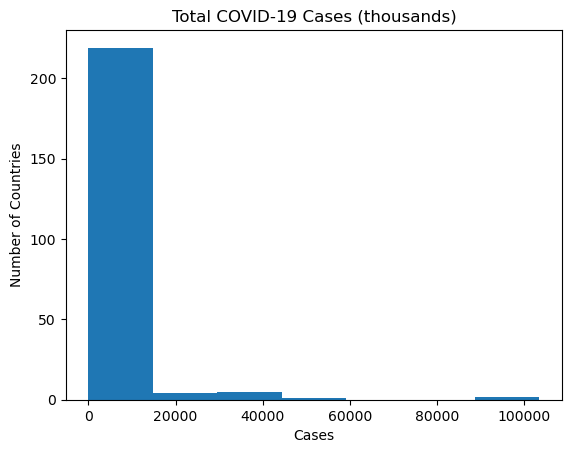

In [29]:
plt.hist(covidtotals['total_cases']/1000, bins=7)
plt.xlabel('Cases')
plt.ylabel('Number of Countries')
plt.title('Total COVID-19 Cases (thousands)')
plt.show()


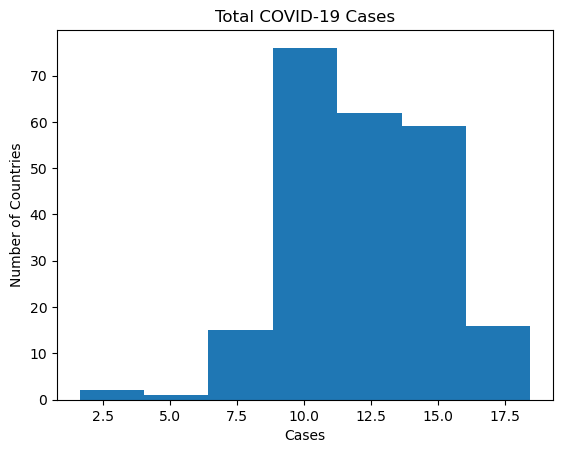

In [30]:
covidlogs = covidtotalsonly.copy()
for col in covidlogs.columns[1:]:
    covidlogs[col] = np.log1p(covidlogs[col])
plt.hist(covidlogs['total_cases'], bins=7)
plt.xlabel('Cases')
plt.ylabel('Number of Countries')
plt.title('Total COVID-19 Cases')
plt.show()